In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

import torch
from torch import Tensor as T
import kornia as K
from PIL import Image

import warnings
import torch.nn.functional as F
from typing import Any
from tqdm import tqdm
import itertools
from transformers import AutoImageProcessor, AutoModel

warnings.simplefilter("ignore")


device = K.utils.get_cuda_device_if_available(0)
print("device : ", device)

ROOT = Path("/kaggle").absolute()  # /kaggle
DATA = ROOT / "input" / "image-matching-challenge-2024"
TRAIN = DATA / "train"
TEST = DATA / "test"
print("ROOT : ", ROOT)

device :  cuda:0
ROOT :  /kaggle


In [2]:
def load_torch_image(file_name: Path | str, device=torch.device("cpu")):
    """Loads an image and adds batch dimension"""
    img = K.io.load_image(file_name, K.io.ImageLoadType.RGB32, device=device)[None, ...]
    return img


def embed_images(
    paths: list[Path],  # 処理する画像ファイルのパスリスト
    model_name: str,  # 画像埋め込みに使用するモデル名
    device: torch.device = torch.device("cpu"),
) -> torch.Tensor:
    """画像の埋め込みベクトルを計算します。

    返り値は shape が [len(filenames), output_dim] のテンソルです。
    """
    processor = AutoImageProcessor.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name).eval().to(device)

    embeddings = []

    for i, path in tqdm(enumerate(paths), desc="Global descriptors"):
        image = load_torch_image(path)

        with torch.inference_mode():
            inputs = processor(images=image, return_tensors="pt", do_rescale=False).to(device)
            outputs = model(**inputs)  # last_hidden_state and pooled

            # 最後の隠れ層の全てのステートに対して最大プーリングを行いますが、fastprogress は除外します
            # 距離をより良い方法で計算するために正規化を行います
            embedding = F.normalize(outputs.last_hidden_state[:, 1:].max(dim=1)[0], dim=-1, p=2)

        embeddings.append(embedding.detach().cpu())
    return torch.cat(embeddings, dim=0)


def get_pairs_exhaustive(lst: list[Any]) -> list[tuple[int, int]]:
    """リストのすべての可能なインデックスペアを取得します"""
    return list(itertools.combinations(range(len(lst)), 2))


def get_image_pairs(
    paths: list[Path],
    model_name: str,
    similarity_threshold: float = 0.6,
    tolerance: int = 1000,
    min_matches: int = 20,
    exhaustive_if_less: int = 20,
    p: float = 2.0,
    device: torch.device = torch.device("cpu"),
) -> list[tuple[int, int]]:
    """類似した画像のペアを取得します"""

    if len(paths) <= exhaustive_if_less:
        return get_pairs_exhaustive(paths)

    matches = []

    # 画像を埋め込み、フィルタリングのための距離を計算する
    embeddings = embed_images(paths, model_name, device)  # shape: [len(filenames), output_dim]
    distances = torch.cdist(embeddings, embeddings, p=p)  # shape: [len(filenames), len(filenames)]
    print(embeddings.shape, distances.shape)

    # 類似度閾値を超えるペアを削除する（十分な数がある場合）
    mask = distances <= similarity_threshold
    image_indices = np.arange(len(paths))

    for current_image_index in range(len(paths)):
        mask_row = mask[current_image_index]
        indices_to_match = image_indices[mask_row]

        # 閾値以下のマッチが十分にない場合、最も類似したものを選ぶ
        if len(indices_to_match) < min_matches:
            indices_to_match = np.argsort(distances[current_image_index])[:min_matches]

        for other_image_index in indices_to_match:
            # 自分自身とのマッチングをスキップする
            if other_image_index == current_image_index:
                continue

            # 特定の距離許容値以下である必要がある
            # 十分なマッチがない画像については、最も類似したものを選んだため、
            # すべての画像が分析対象の画像と非常に異なる可能性がある
            if distances[current_image_index, other_image_index] < tolerance:
                # 冗長性を避けるために、ソートされた形式でペアを追加する
                matches.append(tuple(sorted((current_image_index, other_image_index.item()))))

    index_pairs = sorted(list(set(matches)))

    return distances, index_pairs

In [3]:
def plot_img_by_index_pairs(index: tuple[int, int], images_list: list[Path], distances: T):
    """Plots a pair of images by index"""
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    dist = distances[index[0], index[1]].item()
    scene = str(images_list[0]).split("/")[-3]

    for i, idx in enumerate(index):
        img = Image.open(images_list[idx])
        ax[i].imshow(img)
        ax[i].axis("off")
        ax[i].set_title(f"Image {idx} : {images_list[idx].name}")
    fig.suptitle(f"{scene} | Distance : {dist:.4f}")

    plt.show()


def color_by_index(df, index_pairs):
    styles = df.copy()
    styles.iloc[:, :] = ""
    for idx in index_pairs:
        #         styles.iloc[idx] = 'color: %s' % 'yellow'
        styles.iloc[idx] = "color: %s" % "red"

    return styles

In [4]:
def distance_df(df, scene, images_list, index_pairs, distances):
    for index_pair in index_pairs:
        index_first, index_last = index_pair
        imgname_first = images_list[index_first].name
        imgname_last = images_list[index_last].name
        distance = distances[index_first, index_last]

        df_add = pd.DataFrame({"scene": scene, "image1": imgname_first, "image2": imgname_last, "distance": round(distance.item(), 4)}, index=[0])
        df = pd.concat([df, df_add], ignore_index=True)
    return df

In [5]:
dist_df_all = pd.DataFrame(columns=["scene", "image1", "image2", "distance"])
Path("distances").mkdir(exist_ok=True)
for scene_p in Path(TRAIN).iterdir():
    if not scene_p.is_dir():
        continue
    print(scene_p)
    images_list = sorted((scene_p / "images/").glob("*.png"))

    distances, index_pairs = get_image_pairs(
        paths=images_list,
        model_name="/kaggle/input/dinov2/pytorch/base/1",
        similarity_threshold=0.999,
        exhaustive_if_less=5,
        tolerance=0.999,
        min_matches=5,
        device=device,
    )
    image_names = [image.stem for image in images_list]

    distances = np.round(distances, 4)
    distances[distances < 0.001] = np.nan

    dist_df_scene = pd.DataFrame(np.array(distances))
    dist_df_scene.columns = image_names
    dist_df_scene.index = image_names
    dist_df_scene.to_csv(f"distances/distances_{scene_p.stem}.csv")

    dist_df_all = distance_df(dist_df_all, scene_p.stem, images_list, index_pairs, distances)
dist_df_all.to_csv("distances/distances.csv", index=False)

/kaggle/input/image-matching-challenge-2024/train/transp_obj_glass_cup


Global descriptors: 36it [00:27,  1.29it/s]


torch.Size([36, 768]) torch.Size([36, 36])
/kaggle/input/image-matching-challenge-2024/train/dioscuri


Global descriptors: 70it [00:02, 26.28it/s]


torch.Size([70, 768]) torch.Size([70, 70])
/kaggle/input/image-matching-challenge-2024/train/transp_obj_glass_cylinder


Global descriptors: 36it [00:43,  1.22s/it]


torch.Size([36, 768]) torch.Size([36, 36])
/kaggle/input/image-matching-challenge-2024/train/church


Global descriptors: 111it [00:03, 29.96it/s]


torch.Size([111, 768]) torch.Size([111, 111])
/kaggle/input/image-matching-challenge-2024/train/multi-temporal-temple-baalshamin


Global descriptors: 75it [00:12,  6.07it/s]


torch.Size([75, 768]) torch.Size([75, 75])
/kaggle/input/image-matching-challenge-2024/train/lizard


Global descriptors: 727it [00:22, 32.92it/s]


torch.Size([727, 768]) torch.Size([727, 727])
/kaggle/input/image-matching-challenge-2024/train/pond


Global descriptors: 1148it [00:35, 32.34it/s]


torch.Size([1148, 768]) torch.Size([1148, 1148])


In [27]:
dist = pd.read_csv("distances/distances.csv")

In [25]:
# 各シーンごとに最大距離のペアを取得
dist.groupby("scene").apply(lambda x: x.loc[x["distance"].idxmax()])[["image1", "image2", "distance"]]

,image1,image2,distance
scene,,,
church,00019.png,00098.png,0.4324
dioscuri,3dom_fbk_img_1564.png,dioscuria_147.png,0.4611
lizard,00159.png,00570.png,0.5552
multi-temporal-temple-baalshamin,19577278428_e8044e854b_o.png,pict0821.png,0.4366
pond,00195.png,01066.png,0.5578
transp_obj_glass_cup,01.png,34.png,0.1990
transp_obj_glass_cylinder,dsc_8242.png,dsc_8249.png,0.1717


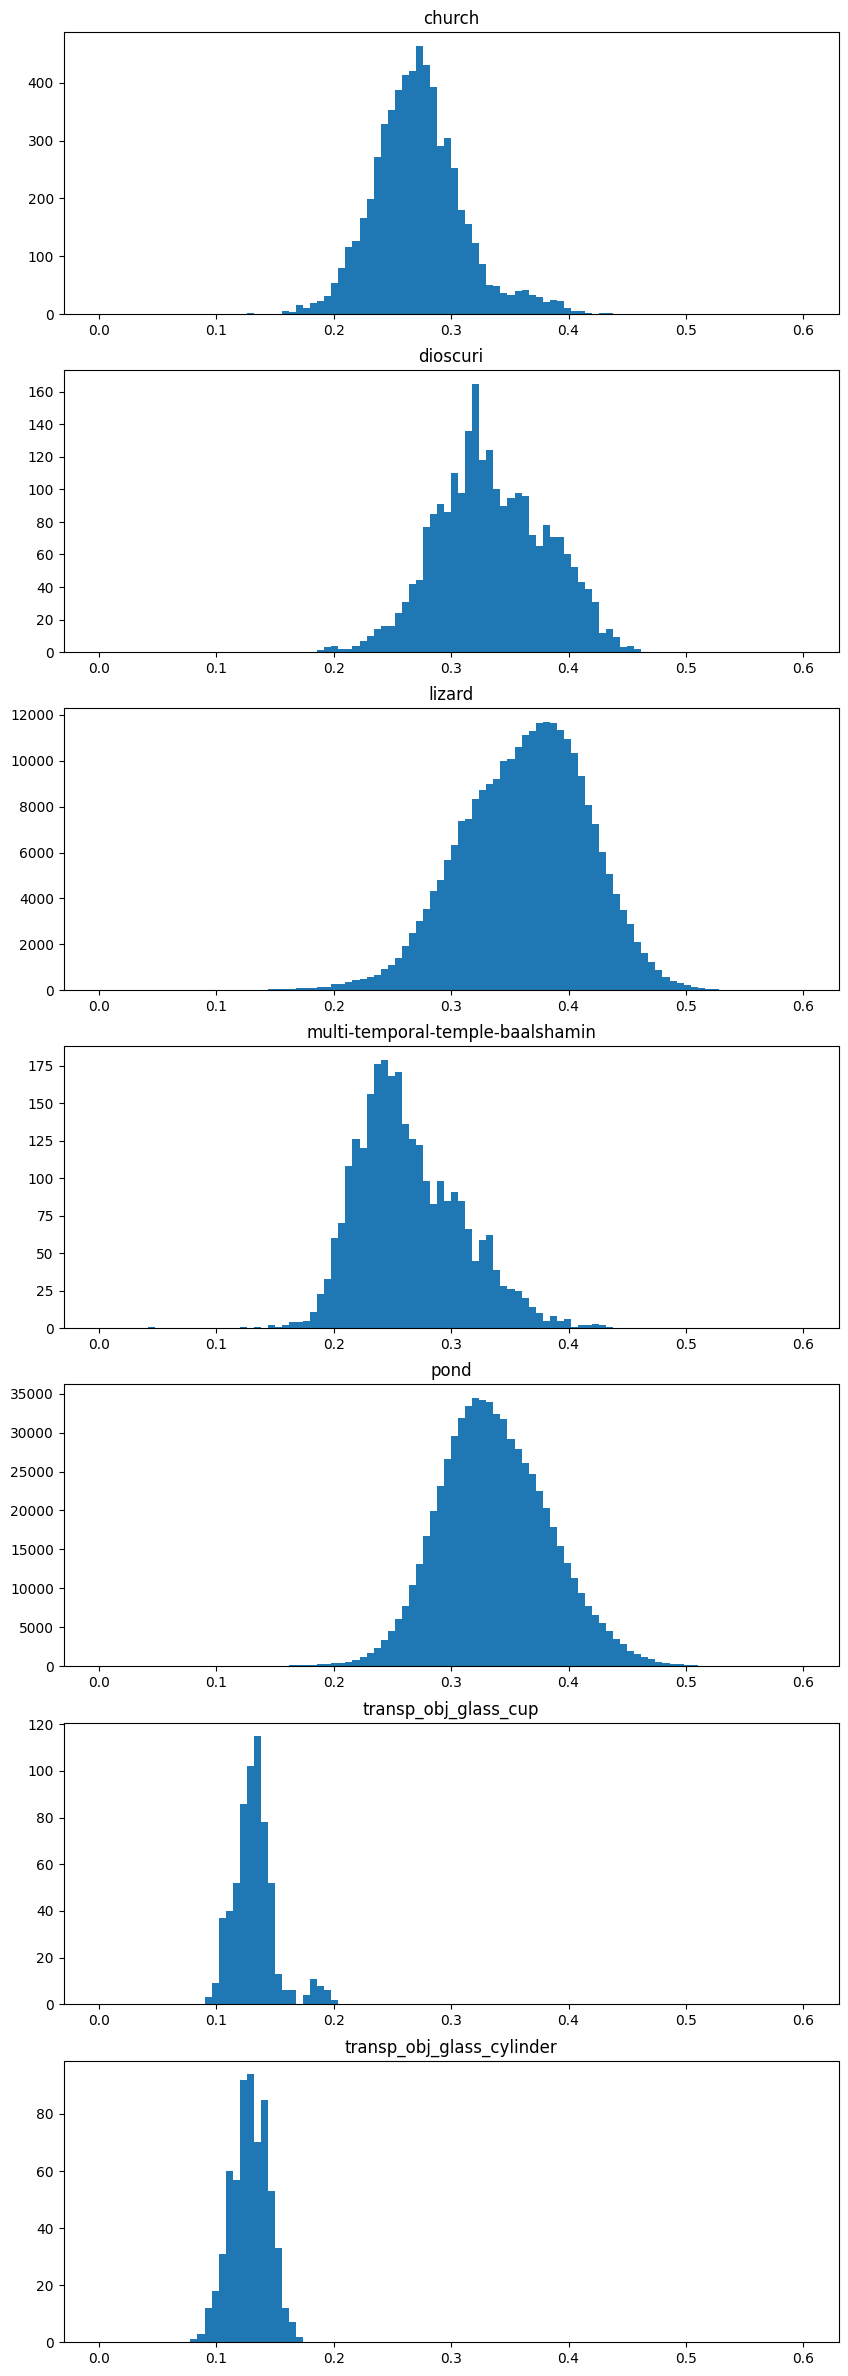

In [24]:
scenes = sorted(dist["scene"].unique())
fig, ax = plt.subplots(7, 1, figsize=(10, 30))
for i, scene in enumerate(scenes):
    ax[i].hist(dist[dist["scene"] == scene]["distance"], bins=100, range=(0, 0.6))
    ax[i].set_title(scene)

In [43]:
dist_scene = pd.read_csv("distances/distances_pond.csv", index_col=0)
dist_scene

,00001,00002,00003,00004,00005,00006,00007,00008,00009,00010,...,01139,01140,01141,01142,01143,01144,01145,01146,01147,01148
1,NaN,0.1628,0.3070,0.2402,0.2379,0.2257,0.2259,0.2943,0.2295,0.2519,...,0.3987,0.4095,0.3708,0.3985,0.4084,0.3563,0.3766,0.4179,0.3886,0.3402
2,0.1628,NaN,0.2899,0.2481,0.2383,0.2296,0.2330,0.2647,0.2284,0.2375,...,0.3679,0.4029,0.3627,0.3946,0.3868,0.3461,0.3746,0.4014,0.3605,0.3363
3,0.3070,0.2899,NaN,0.2260,0.2502,0.2736,0.2768,0.2234,0.2552,0.2456,...,0.3270,0.4480,0.4099,0.4575,0.4053,0.3977,0.4235,0.4222,0.3299,0.3908
4,0.2402,0.2481,0.2260,NaN,0.1603,0.1700,0.1807,0.2623,0.1941,0.2282,...,0.3484,0.3719,0.3337,0.3916,0.3999,0.3321,0.3523,0.4031,0.3426,0.3183
5,0.2379,0.2383,0.2502,0.1603,NaN,0.1593,0.1825,0.2486,0.1904,0.2198,...,0.3387,0.3725,0.3215,0.3806,0.3921,0.3264,0.3481,0.3945,0.3325,0.3145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144,0.3563,0.3461,0.3977,0.3321,0.3264,0.3229,0.3247,0.3862,0.3211,0.3608,...,0.3895,0.3499,0.3307,0.2957,0.4185,NaN,0.2965,0.3803,0.3894,0.3160
1145,0.3766,0.3746,0.4235,0.3523,0.3481,0.3511,0.3464,0.4114,0.3489,0.3767,...,0.3891,0.3150,0.3116,0.3515,0.4245,0.2965,NaN,0.3647,0.3836,0.2980
1146,0.4179,0.4014,0.4222,0.4031,0.3945,0.4000,0.3956,0.4102,0.3893,0.3874,...,0.4231,0.3841,0.4161,0.3918,0.4284,0.3803,0.3647,NaN,0.4149,0.3775
1147,0.3886,0.3605,0.3299,0.3426,0.3325,0.3429,0.3497,0.3239,0.3459,0.3316,...,0.1396,0.4130,0.2959,0.4638,0.4145,0.3894,0.3836,0.4149,NaN,0.3647


In [44]:
# 各画像がもつ他の画像との最小距離
dist_scene.min(axis=0).sort_values(ascending=False).head(10)

01127    0.3494
00989    0.3304
01129    0.3224
01061    0.2983
01081    0.2901
01058    0.2898
01095    0.2890
00061    0.2871
01111    0.2856
01110    0.2855
dtype: float64